In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import pickle
import json
from pathlib import Path
import time
from tqdm import tqdm
from joblib import Parallel, delayed, dump, load
import random
import _utilities

import torch
import torch.nn as nn
import torch.nn.functional as F
import mlflow
from sklearn.preprocessing import StandardScaler

In [2]:
with open( './cells_of_interest.json', 'r') as f:
   cells_of_interest = json.load(f)

In [3]:
len(cells_of_interest)

334

In [4]:
with open('./cells_info.pickle', 'rb') as f:
    cells_info = pickle.load(f)
# cells_info['ABal']
with open('./embryo_cells_info.pickle', 'rb') as f:
    embryo_cells_info = pickle.load(f)
# embryo_cells_info['WT-EMB12']['ABal']

In [5]:
embryos_for_test = ['WT-EMB05','WT-EMB12','WT-EMB19','WT-EMB26']
embryos_for_cross_validation = [embryo_name for embryo_name in embryo_cells_info if embryo_name not in embryos_for_test]

In [6]:
print(embryos_for_cross_validation)

['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB27', 'WT-EMB28']


In [7]:
len(embryos_for_cross_validation)

24

# LSTM model

In [8]:
class LSTM(nn.Module):
    def __init__(self, output_size = 334, num_rnn_layer = 1):
        super().__init__()
        self.flat = nn.Flatten() # flatten features
        self.unflat = nn.Unflatten(1, (50,3))  # trajectory input of shape (N, Lx3) to (N, L, 3), where N is batch_size, L=50 is seq_length
        # Hidden layer
        self.rnn = nn.LSTM(3, 3, num_layers=num_rnn_layer, batch_first=True) # (x,y,z)
        # final Output layer
        self.fc_out = nn.LazyLinear(output_size) # output layer

    def forward(self, x, x_extra = None):
        """_summary_

        Parameters
        ----------
        x : tensor
            trajectory features
        x_extra : tensor
            extra features, like start_frame, lifespan, division orientations, by default None

        Returns
        -------
        tensor
            forward pass of (x, x_extra)
        """     
        # trajectory branch
        # convert x from (N, Lx3) to (N, L, 3), where L should be 50
        out = self.unflat(x)
        out, _ = self.rnn(out) # out is of shape (N, L, H_out), where N is batch_size, L is seq_length, H_out is hidden feature size. In our case, out is of shape (N, 50, 3)  
        out = self.flat(out) # to shape (N, 50*3)
        # no extra features as input, only trajectory
        if x_extra is None: 
            out = self.fc_out(out)
        else:
            x_extra = self.flat(x_extra)
            out = torch.cat((out, x_extra), dim = 1)
            out = self.fc_out(out)
        return out

## With Feature StandardScaler

In [10]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device=='cuda':
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

# Batch_size
batch_size = 128

# Prepare data

# train and val data
i = 0
embryos_val = embryos_for_cross_validation[4*i:4*i+4]
embryos_train = [embryo_name for embryo_name in embryos_for_cross_validation if embryo_name not in embryos_val]
X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_train, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = False, flatten = True)
X_val, _, y_val = _utilities.prepare_data_for_model(embryo_cells_info, embryos_val, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = False, flatten = True)
# test data
X_test, _, y_test = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_test, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = False, flatten = True)

# feature normalization
scaler = StandardScaler()
scaler.fit(np.array(X_train))
X_train = scaler.transform(np.array(X_train))
# standardize X_val and X_test
X_val = scaler.transform(np.array(X_val))
X_test = scaler.transform(np.array(X_test))


# Dataset
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_train, dtype=np.float32)), torch.from_numpy(np.array(y_train)).type(torch.LongTensor))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_val, dtype=np.float32)), torch.from_numpy(np.array(y_val)).type(torch.LongTensor))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_test, dtype =np.float32)), torch.from_numpy(np.array(y_test)).type(torch.LongTensor))
# Dataloader 
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Train and Validate model
model = LSTM(output_size=len(cells_of_interest)).to(device)
lr = 0.001
weight_decay=0.1 # L2 regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

num_epochs = 3000
test_interval = 10
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
test_accuracy = []

start_time = time.time()
# Training
for epoch in range(num_epochs):
    acc_train, loss_train = _utilities.train_rnn(model, train_dl, optimizer, device)
    acc_valid, loss_valid = _utilities.evaluate_rnn(model, val_dl, optimizer, device)
    scheduler.step() # adjust lr
    train_loss.append(loss_train)
    train_accuracy.append(acc_train)
    val_loss.append(loss_valid)
    val_accuracy.append(acc_valid)
    print(f'Epoch: {epoch+1:04d}/{num_epochs:04d} | '
          f'Accuracy: {acc_train:.4f} | '
          f'Val_accuracy: {acc_valid:.4f} | '
          f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
    if (epoch+1)%test_interval == 0: # test every 50 epochs
        # Test
        acc_test, _ = _utilities.evaluate_rnn(model, test_dl, optimizer, device)
        test_accuracy.append(acc_test)
        print(f'Test_accuracy: {acc_test:.4f}') 
# Test
acc_test, _ = _utilities.evaluate_rnn(model, test_dl, optimizer, device)
# test_accuracy.append(acc_test)
print(f'Final Test_accuracy: {acc_test:.4f}')

c:\Users\pmcesky\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 0001/3000 | Accuracy: 0.0302 | Val_accuracy: 0.0801 | Time elapsed: 0.01 min
Epoch: 0002/3000 | Accuracy: 0.1031 | Val_accuracy: 0.1602 | Time elapsed: 0.02 min
Epoch: 0003/3000 | Accuracy: 0.1825 | Val_accuracy: 0.2695 | Time elapsed: 0.02 min
Epoch: 0004/3000 | Accuracy: 0.2608 | Val_accuracy: 0.3406 | Time elapsed: 0.03 min
Epoch: 0005/3000 | Accuracy: 0.3251 | Val_accuracy: 0.3982 | Time elapsed: 0.03 min
Epoch: 0006/3000 | Accuracy: 0.3786 | Val_accuracy: 0.4184 | Time elapsed: 0.04 min
Epoch: 0007/3000 | Accuracy: 0.4085 | Val_accuracy: 0.4528 | Time elapsed: 0.04 min
Epoch: 0008/3000 | Accuracy: 0.4449 | Val_accuracy: 0.5022 | Time elapsed: 0.05 min
Epoch: 0009/3000 | Accuracy: 0.4835 | Val_accuracy: 0.5254 | Time elapsed: 0.05 min
Epoch: 0010/3000 | Accuracy: 0.5112 | Val_accuracy: 0.5299 | Time elapsed: 0.06 min
Test_accuracy: 0.5561
Epoch: 0011/3000 | Accuracy: 0.5286 | Val_accuracy: 0.5591 | Time elapsed: 0.06 min
Epoch: 0012/3000 | Accuracy: 0.5449 | Val_accuracy: 0.

In [11]:
print(test_accuracy)

[0.4408682634730539, 0.5988023952095808, 0.6841317365269461, 0.7297904191616766, 0.7537425149700598, 0.7694610778443114, 0.7851796407185628, 0.7949101796407185, 0.7994011976047904, 0.8046407185628742, 0.8098802395209581, 0.8098802395209581, 0.8166167664670658, 0.8158682634730539, 0.8151197604790419, 0.8218562874251497, 0.8226047904191617, 0.8166167664670658, 0.8233532934131736, 0.8233532934131736, 0.8255988023952096, 0.8166167664670658, 0.8241017964071856, 0.8166167664670658, 0.8226047904191617, 0.8241017964071856, 0.8255988023952096, 0.8263473053892215, 0.8218562874251497, 0.8263473053892215, 0.8285928143712575, 0.8241017964071856, 0.8241017964071856, 0.8278443113772455, 0.8315868263473054, 0.8300898203592815, 0.8300898203592815, 0.8233532934131736, 0.8278443113772455, 0.8278443113772455, 0.8300898203592815, 0.8241017964071856, 0.8248502994011976, 0.8285928143712575, 0.8285928143712575, 0.8255988023952096, 0.8241017964071856, 0.8203592814371258, 0.8226047904191617, 0.8255988023952096,

Text(0.5, 1.025, 'LSTM training')

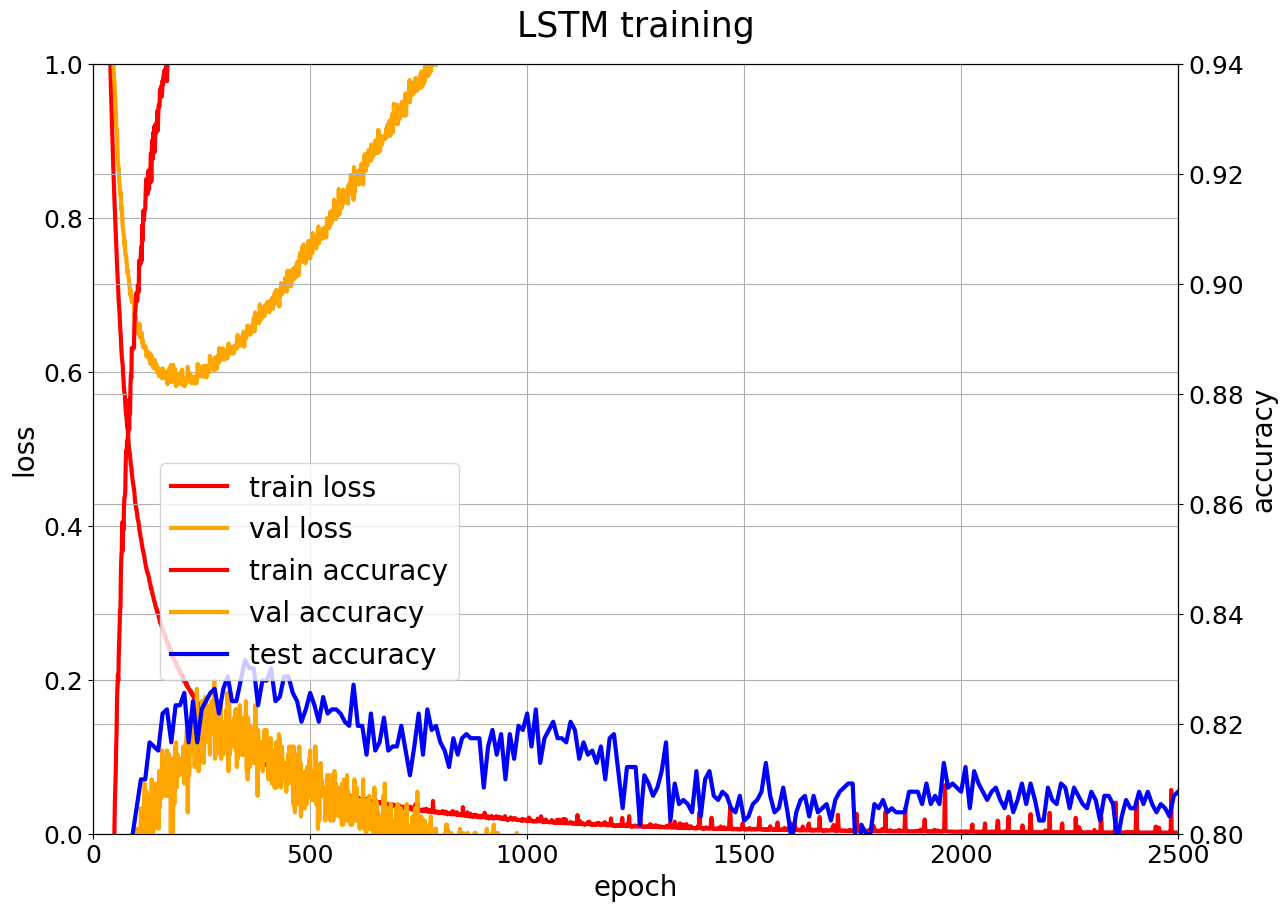

In [12]:
# Adam, l2 weight_decay = 0, lr = 0.001, batch_size = 128, with feature standardization, 2 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,0.94)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.35,0.5), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

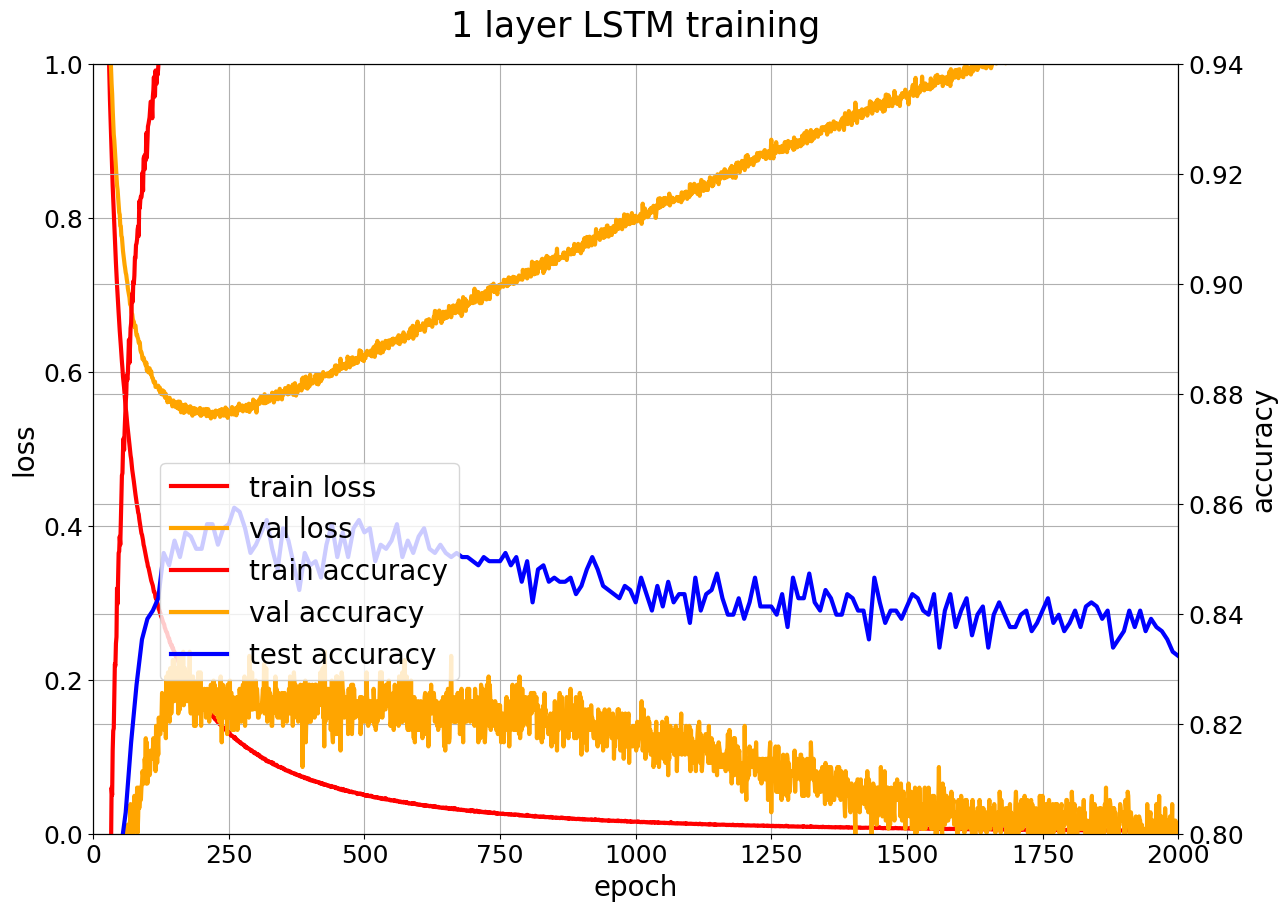

In [19]:
# AdamW, l2 weight_decay = 0.01, lr = 0.001, batch_size = 128, with feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,0.94)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.35,0.5), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

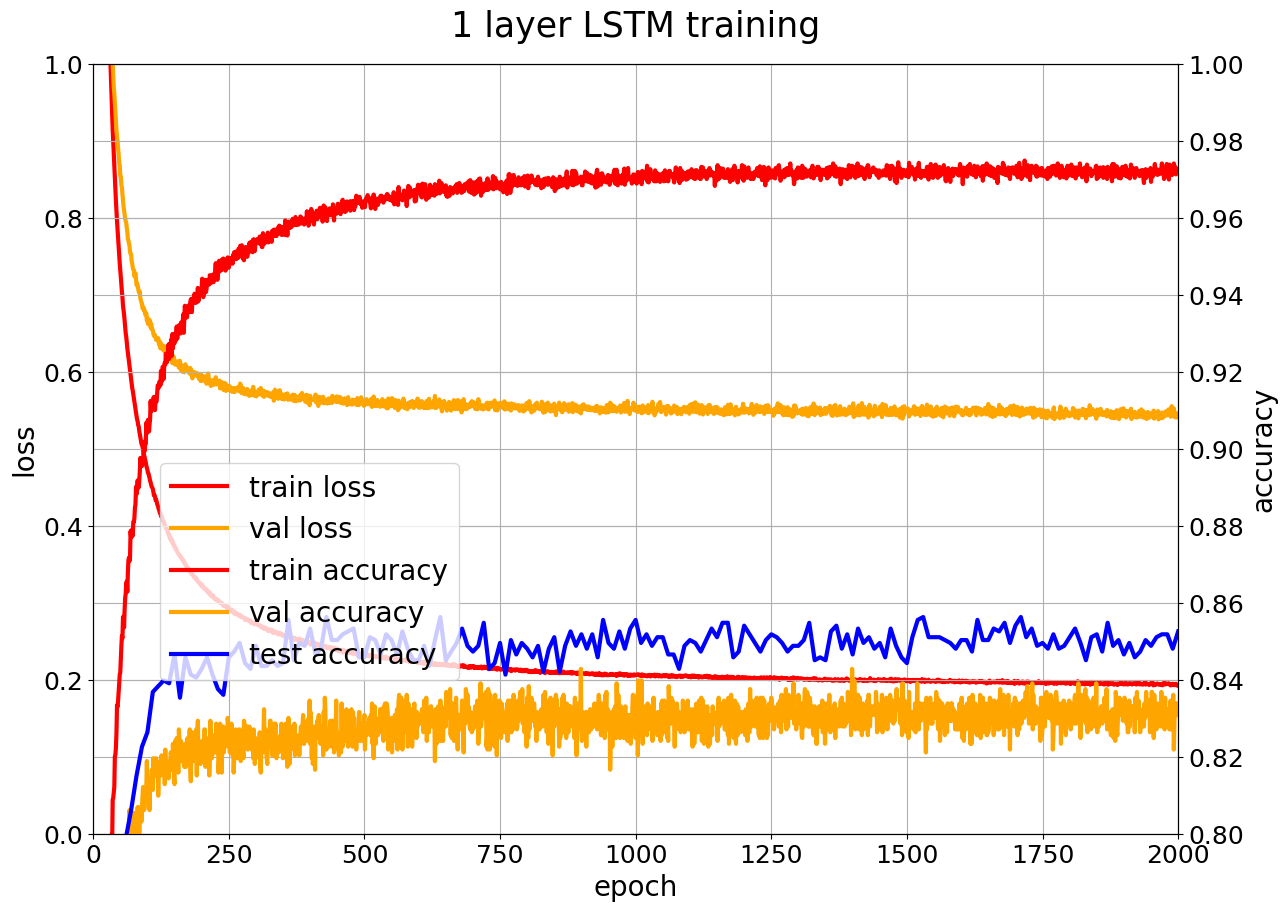

In [22]:
# AdamW, l2 weight_decay = 0.1, lr = 0.001, batch_size = 128, with feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.35,0.5), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

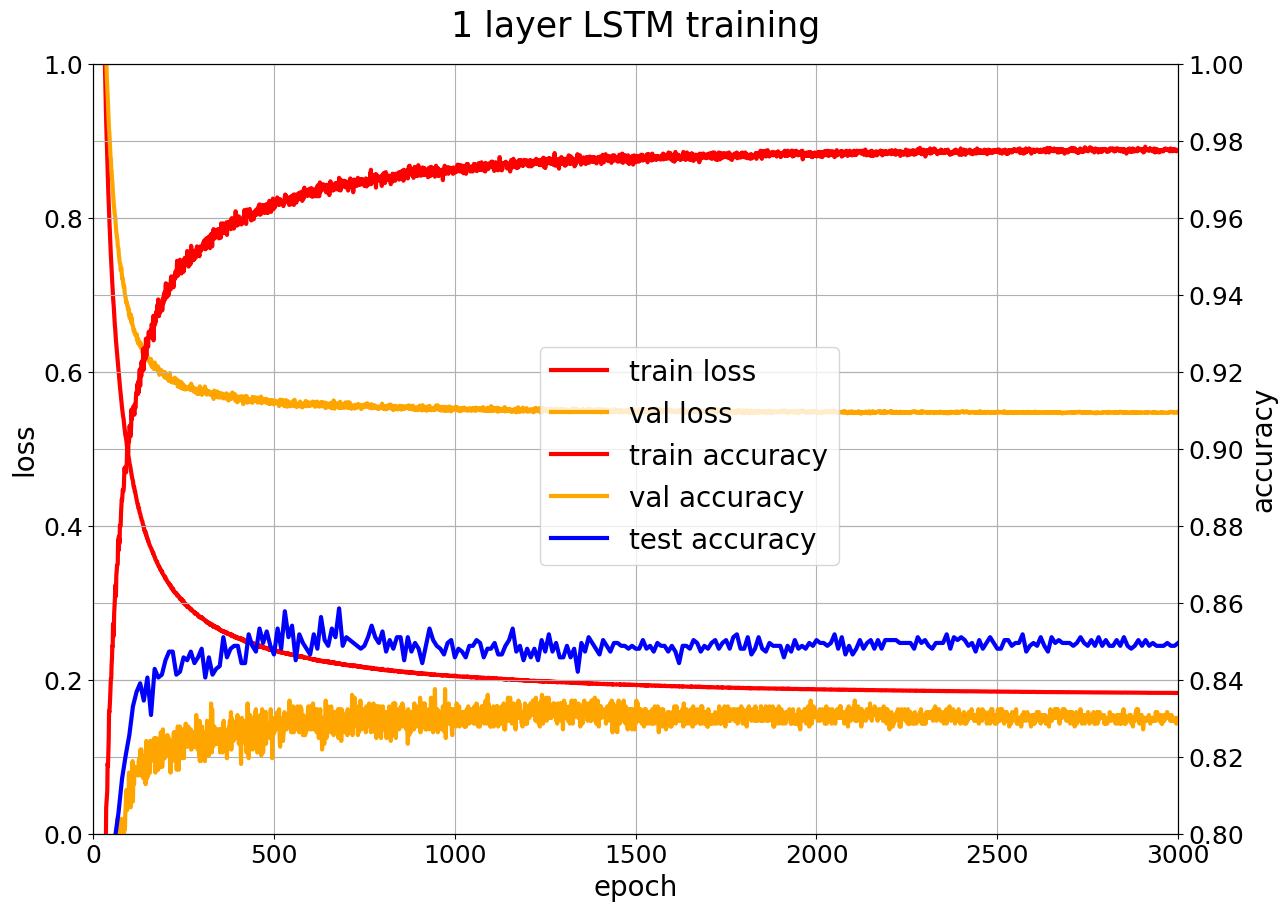

In [11]:
# AdamW, l2 weight_decay = 0.1, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, with feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


**AdamW, l2 weight_decay = 0.1, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, with feature standardization, 1 Layer LSTM, train for 3000 steps is probably enough.**

Text(0.5, 1.025, '1 layer LSTM training')

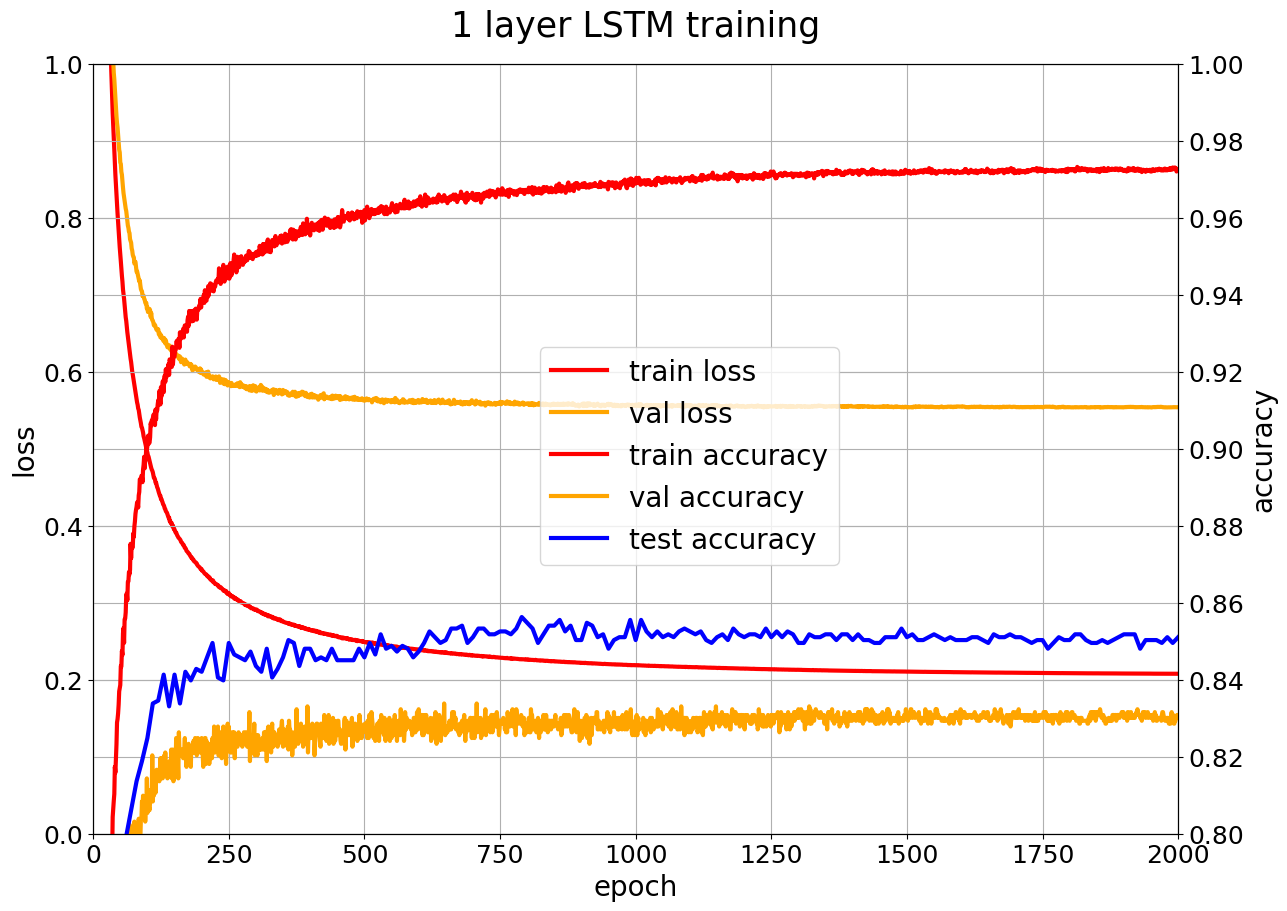

In [41]:
# AdamW, l2 weight_decay = 0.1, lr = 0.001, lr schedule exp decay gamma = 0.998, batch_size = 128, with feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

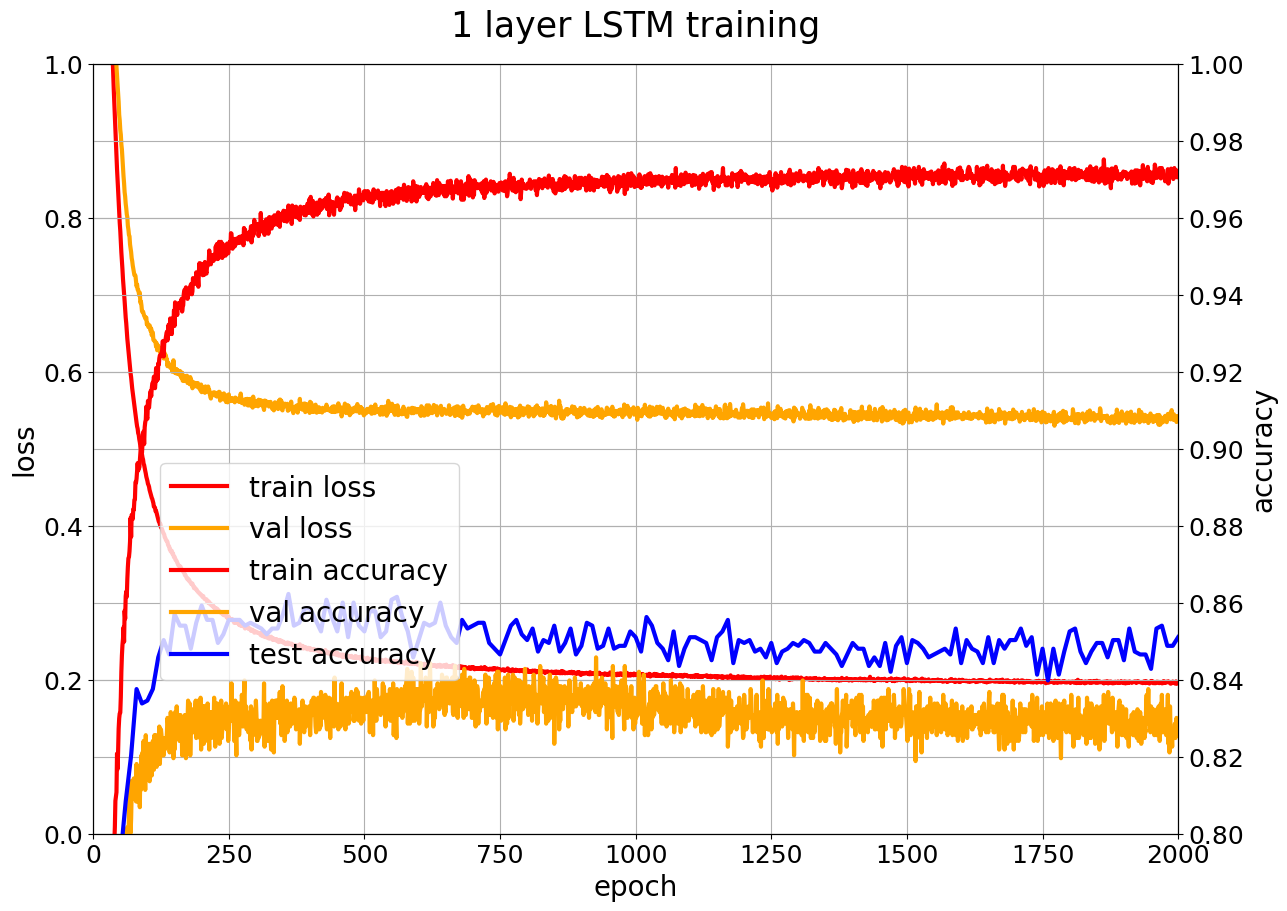

In [30]:
# AdamW, l2 weight_decay = 0.1, dropout=0.5 (this may not take into effect), lr = 0.001, batch_size = 128, with feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.35,0.5), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

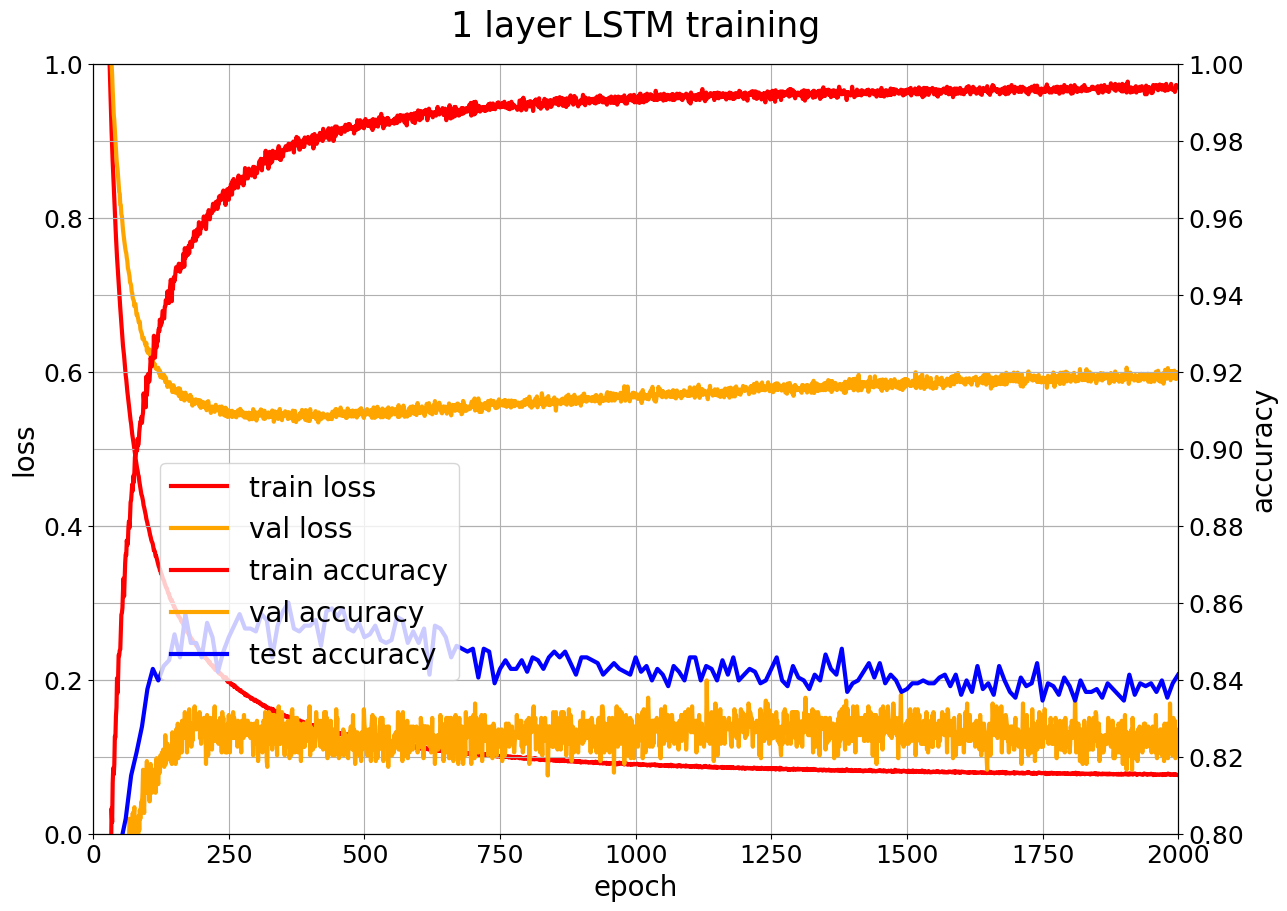

In [25]:
# AdamW, l2 weight_decay = 0.05, lr = 0.001, batch_size = 128, with feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.35,0.5), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

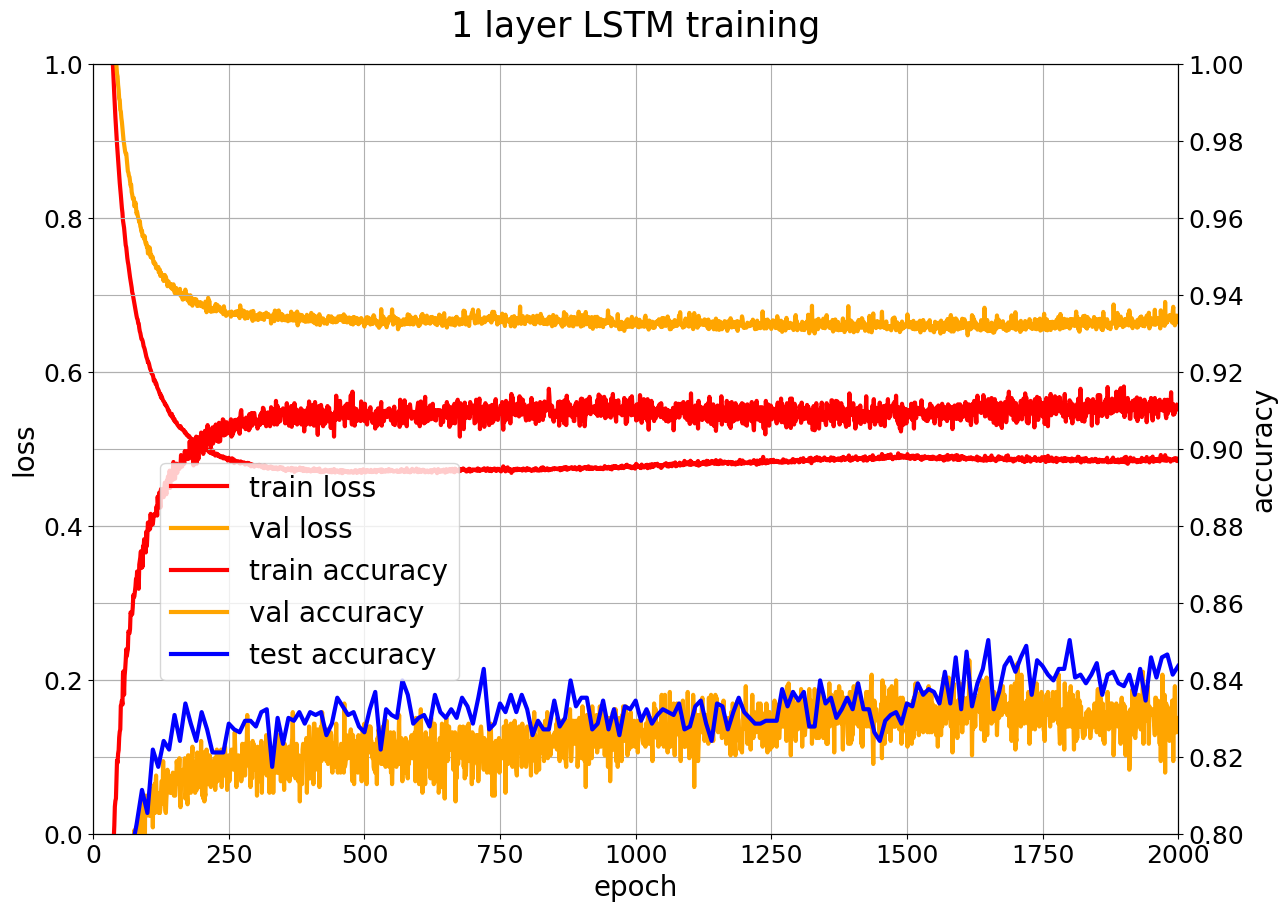

In [27]:
# AdamW, l2 weight_decay = 0.2, lr = 0.001, batch_size = 128, with feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.35,0.5), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

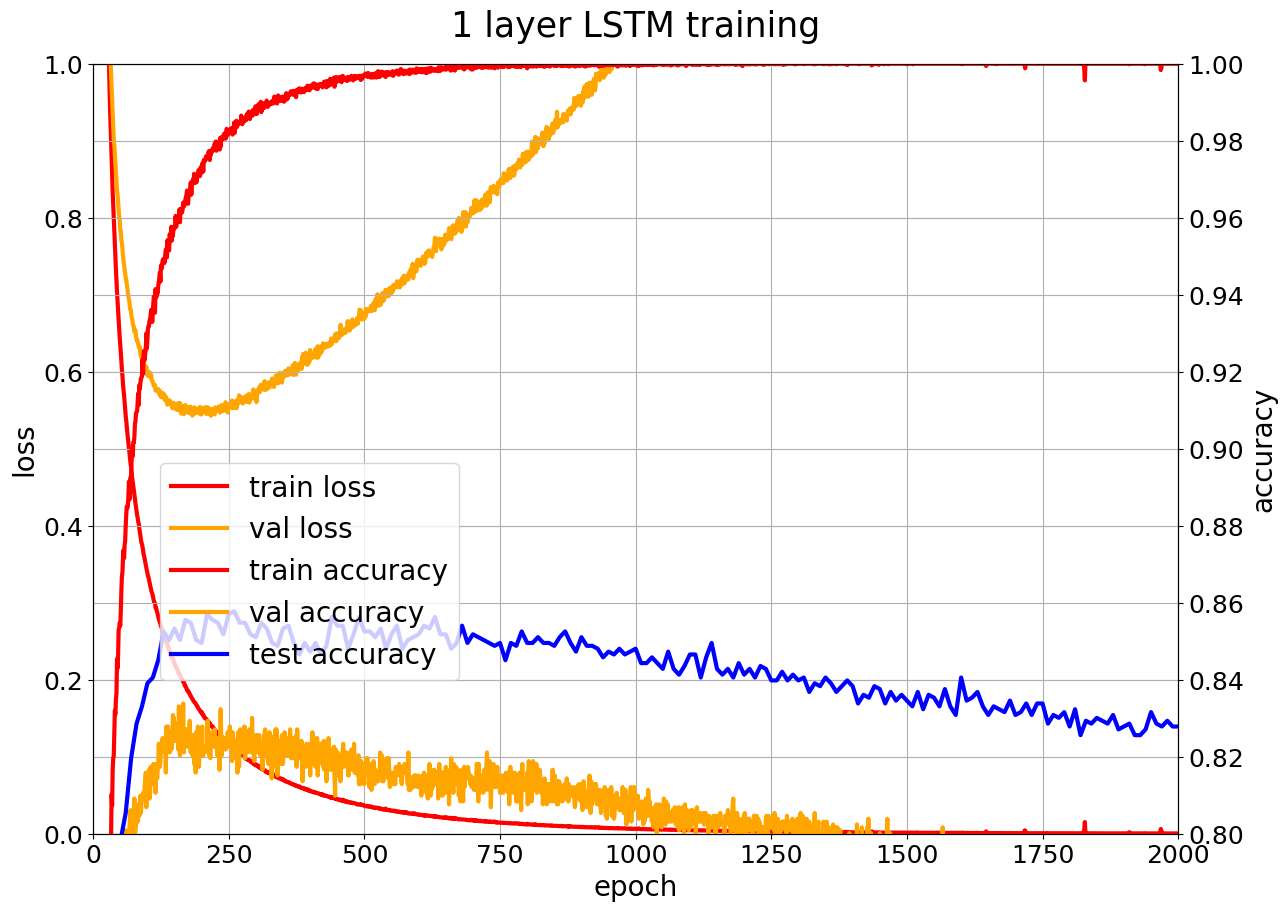

In [17]:
# Adam, l2 weight_decay = 0, lr = 0.001, batch_size = 128, with feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.35,0.5), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, 'LSTM training')

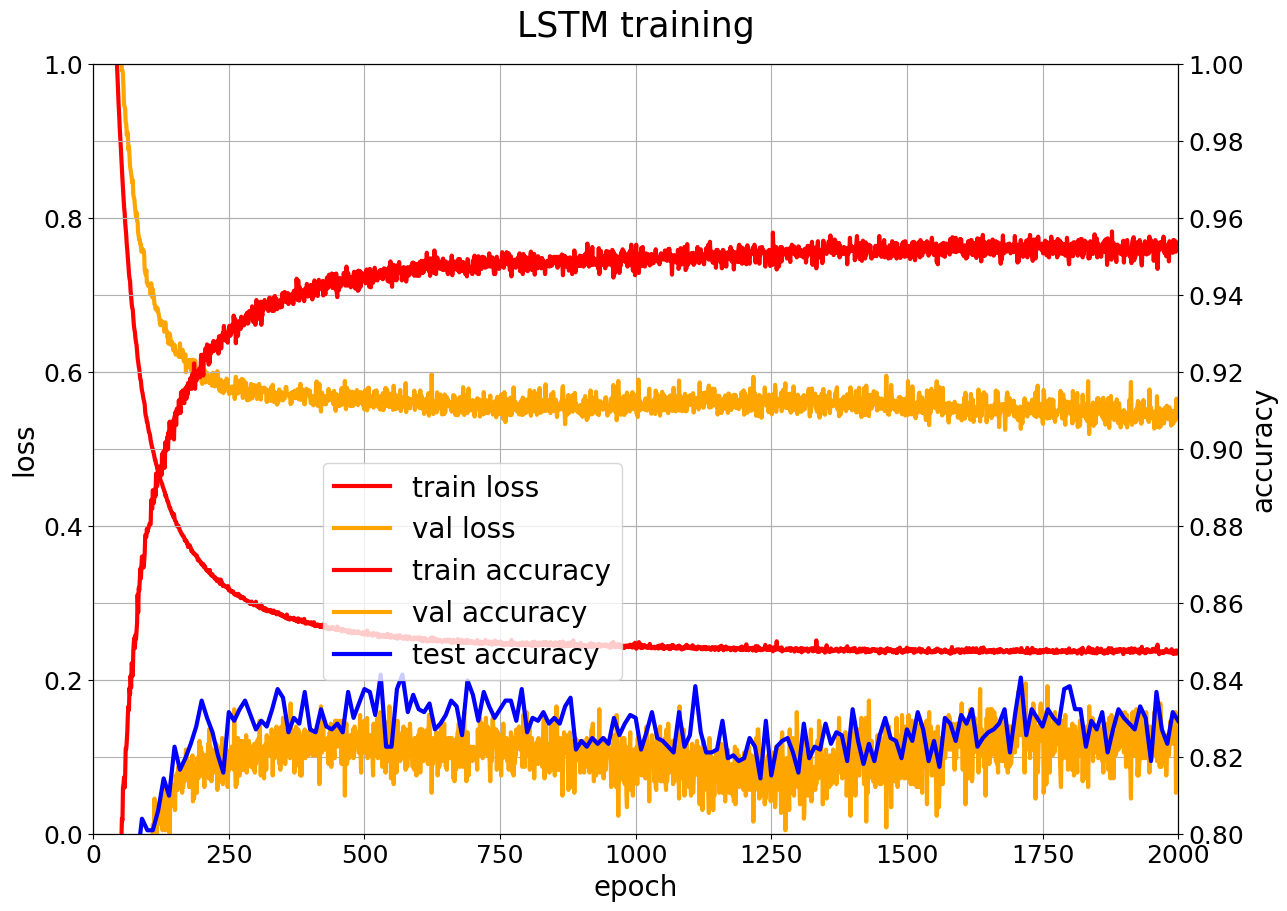

In [14]:
# AdamW, l2 weight_decay = 0.1, lr = 0.001, batch_size = 128, with feature standardization, 2 layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.5,0.5), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('LSTM training', fontsize = 25, y = 1.025)


In [38]:
print(test_accuracy)

[0.7514970059880239, 0.7874251497005988, 0.8083832335329342, 0.8091317365269461, 0.8143712574850299, 0.8218562874251497, 0.8188622754491018, 0.8158682634730539, 0.8218562874251497, 0.8158682634730539, 0.8151197604790419, 0.812125748502994, 0.8143712574850299, 0.813622754491018, 0.8233532934131736, 0.8188622754491018, 0.8211077844311377, 0.8173652694610778, 0.8203592814371258, 0.8203592814371258, 0.8218562874251497, 0.8181137724550899, 0.8188622754491018, 0.8173652694610778, 0.8158682634730539, 0.8166167664670658, 0.8151197604790419, 0.8196107784431138, 0.8173652694610778, 0.8143712574850299, 0.8158682634730539, 0.812874251497006, 0.811377245508982, 0.813622754491018, 0.811377245508982, 0.812125748502994, 0.8151197604790419, 0.812125748502994, 0.811377245508982, 0.8098802395209581, 0.813622754491018, 0.812874251497006, 0.8151197604790419, 0.8151197604790419, 0.8158682634730539, 0.812874251497006, 0.8076347305389222, 0.8053892215568862, 0.8083832335329342, 0.8098802395209581]


## Without Feature StandardScaler

In [11]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device=='cuda':
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

# Batch_size
batch_size = 128

# Prepare data

# train and val data
i = 0
embryos_val = embryos_for_cross_validation[4*i:4*i+4]
embryos_train = [embryo_name for embryo_name in embryos_for_cross_validation if embryo_name not in embryos_val]
X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_train, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = False, flatten = True)
X_val, _, y_val = _utilities.prepare_data_for_model(embryo_cells_info, embryos_val, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = False, flatten = True)
# test data
X_test, _, y_test = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_test, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = False, flatten = True)

## feature normalization
# scaler = StandardScaler()
# scaler.fit(np.array(X_train))
# X_train = scaler.transform(np.array(X_train))
# # standardize X_val and X_test
# X_val = scaler.transform(np.array(X_val))
# X_test = scaler.transform(np.array(X_test))


# Dataset
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_train, dtype=np.float32)), torch.from_numpy(np.array(y_train)).type(torch.LongTensor))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_val, dtype=np.float32)), torch.from_numpy(np.array(y_val)).type(torch.LongTensor))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_test, dtype =np.float32)), torch.from_numpy(np.array(y_test)).type(torch.LongTensor))
# Dataloader 
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Train and Validate model
model = LSTM(output_size=len(cells_of_interest)).to(device)
lr = 0.001
weight_decay=0.2 # L2 regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

num_epochs = 3000
test_interval = 10
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
test_accuracy = []

start_time = time.time()
# Training
for epoch in range(num_epochs):
    acc_train, loss_train = _utilities.train_rnn(model, train_dl, optimizer, device, gradient_clip=True)
    acc_valid, loss_valid = _utilities.evaluate_rnn(model, val_dl, optimizer, device)
    scheduler.step() # adjust lr
    train_loss.append(loss_train)
    train_accuracy.append(acc_train)
    val_loss.append(loss_valid)
    val_accuracy.append(acc_valid)
    print(f'Epoch: {epoch+1:04d}/{num_epochs:04d} | '
          f'Accuracy: {acc_train:.4f} | '
          f'Val_accuracy: {acc_valid:.4f} | '
          f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
    if (epoch+1)%test_interval == 0: # test every 50 epochs
        # Test
        acc_test, _ = _utilities.evaluate_rnn(model, test_dl, optimizer, device)
        test_accuracy.append(acc_test)
        print(f'Test_accuracy: {acc_test:.4f}') 
# Test
acc_test, _ = _utilities.evaluate_rnn(model, test_dl, optimizer, device)
# test_accuracy.append(acc_test)
print(f'Final Test_accuracy: {acc_test:.4f}')

Epoch: 0001/3000 | Accuracy: 0.0084 | Val_accuracy: 0.0269 | Time elapsed: 0.01 min
Epoch: 0002/3000 | Accuracy: 0.0481 | Val_accuracy: 0.0898 | Time elapsed: 0.01 min
Epoch: 0003/3000 | Accuracy: 0.1304 | Val_accuracy: 0.1557 | Time elapsed: 0.02 min
Epoch: 0004/3000 | Accuracy: 0.1961 | Val_accuracy: 0.2260 | Time elapsed: 0.03 min
Epoch: 0005/3000 | Accuracy: 0.2874 | Val_accuracy: 0.2949 | Time elapsed: 0.03 min
Epoch: 0006/3000 | Accuracy: 0.3380 | Val_accuracy: 0.3802 | Time elapsed: 0.04 min
Epoch: 0007/3000 | Accuracy: 0.4084 | Val_accuracy: 0.4266 | Time elapsed: 0.05 min
Epoch: 0008/3000 | Accuracy: 0.4663 | Val_accuracy: 0.4768 | Time elapsed: 0.05 min
Epoch: 0009/3000 | Accuracy: 0.4988 | Val_accuracy: 0.5135 | Time elapsed: 0.06 min
Epoch: 0010/3000 | Accuracy: 0.5494 | Val_accuracy: 0.5254 | Time elapsed: 0.06 min
Test_accuracy: 0.5674
Epoch: 0011/3000 | Accuracy: 0.5572 | Val_accuracy: 0.5636 | Time elapsed: 0.07 min
Epoch: 0012/3000 | Accuracy: 0.5843 | Val_accuracy: 0.

Text(0.5, 1.025, '1 layer LSTM training')

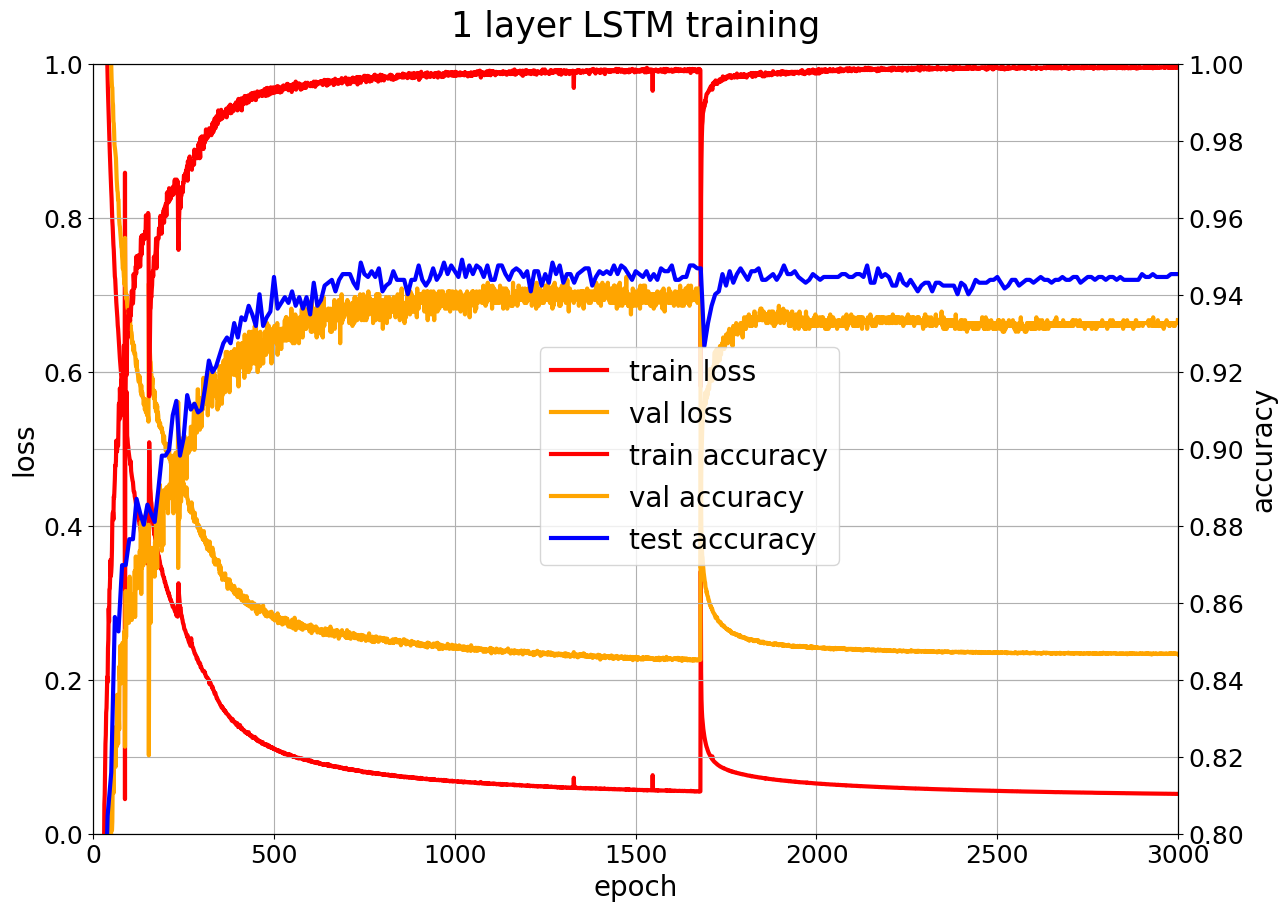

In [10]:
# AdamW, l2 weight_decay = 0.1, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, without feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

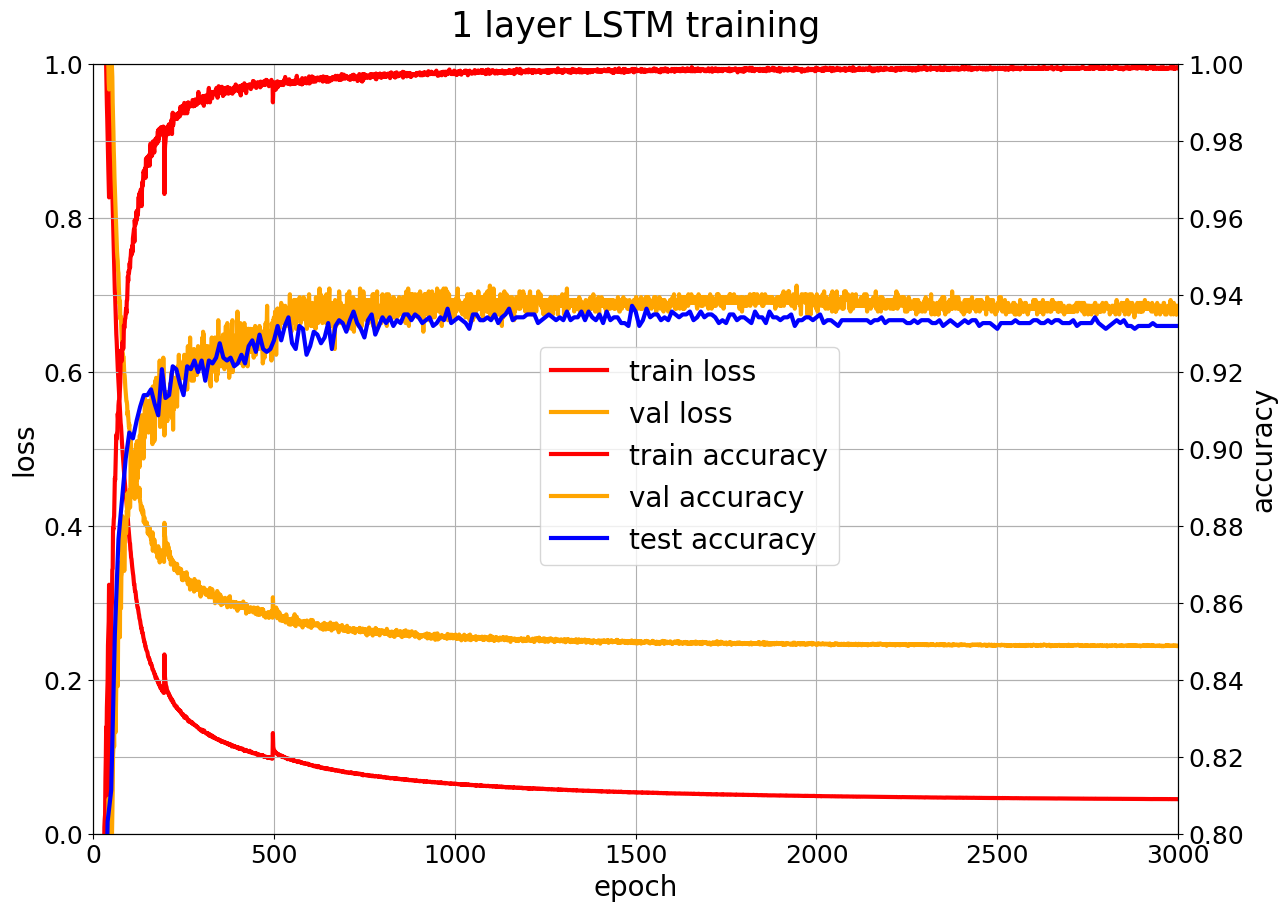

In [10]:
# AdamW, l2 weight_decay = 0.1, lr = 0.001, lr schedule exp decay gamma = 0.999, with clip_grad_norm_0.01, batch_size = 128, without feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

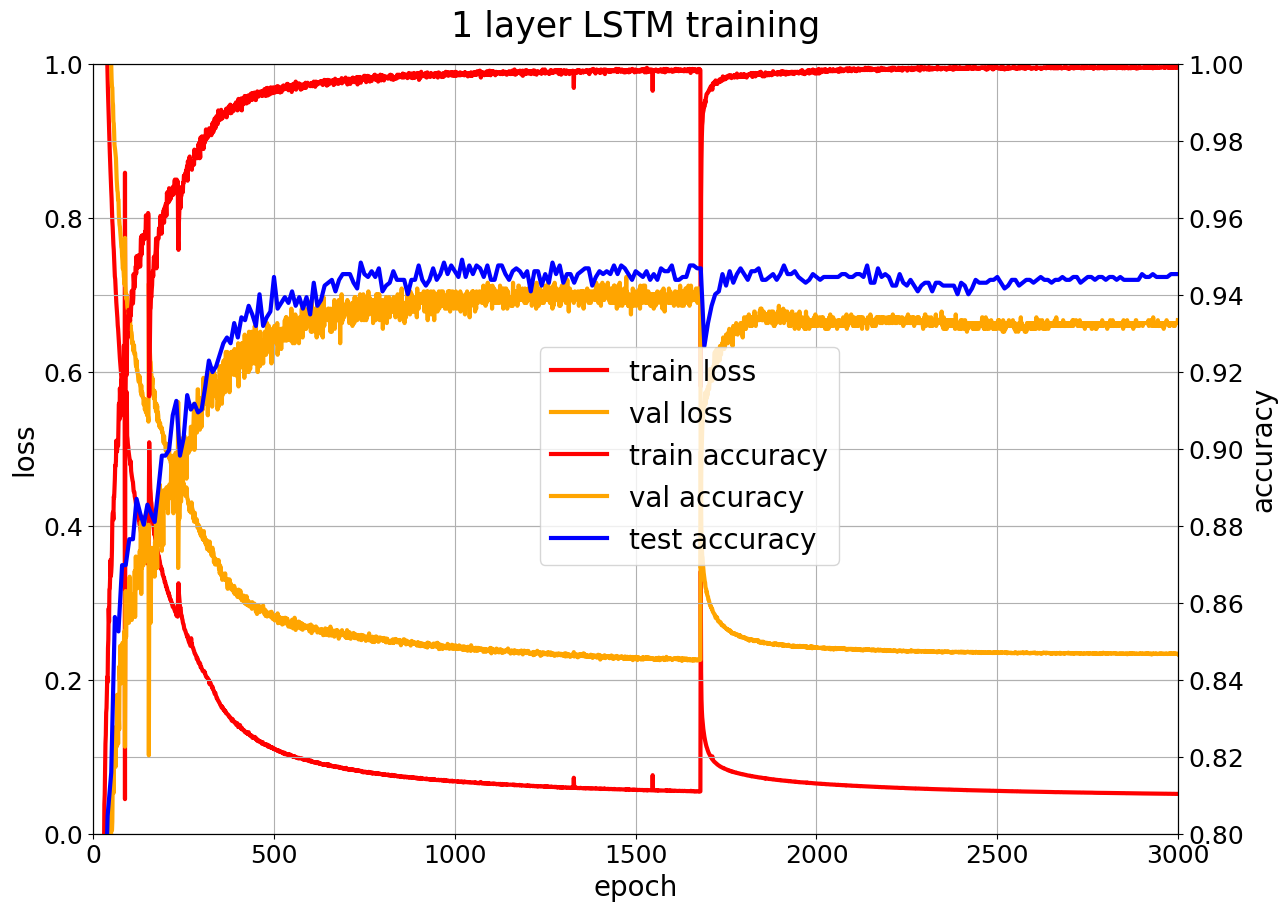

In [ ]:
# AdamW, l2 weight_decay = 0.05, lr = 0.001, lr schedule exp decay gamma = 0.999, with clip_grad_norm_0.01, batch_size = 128, without feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

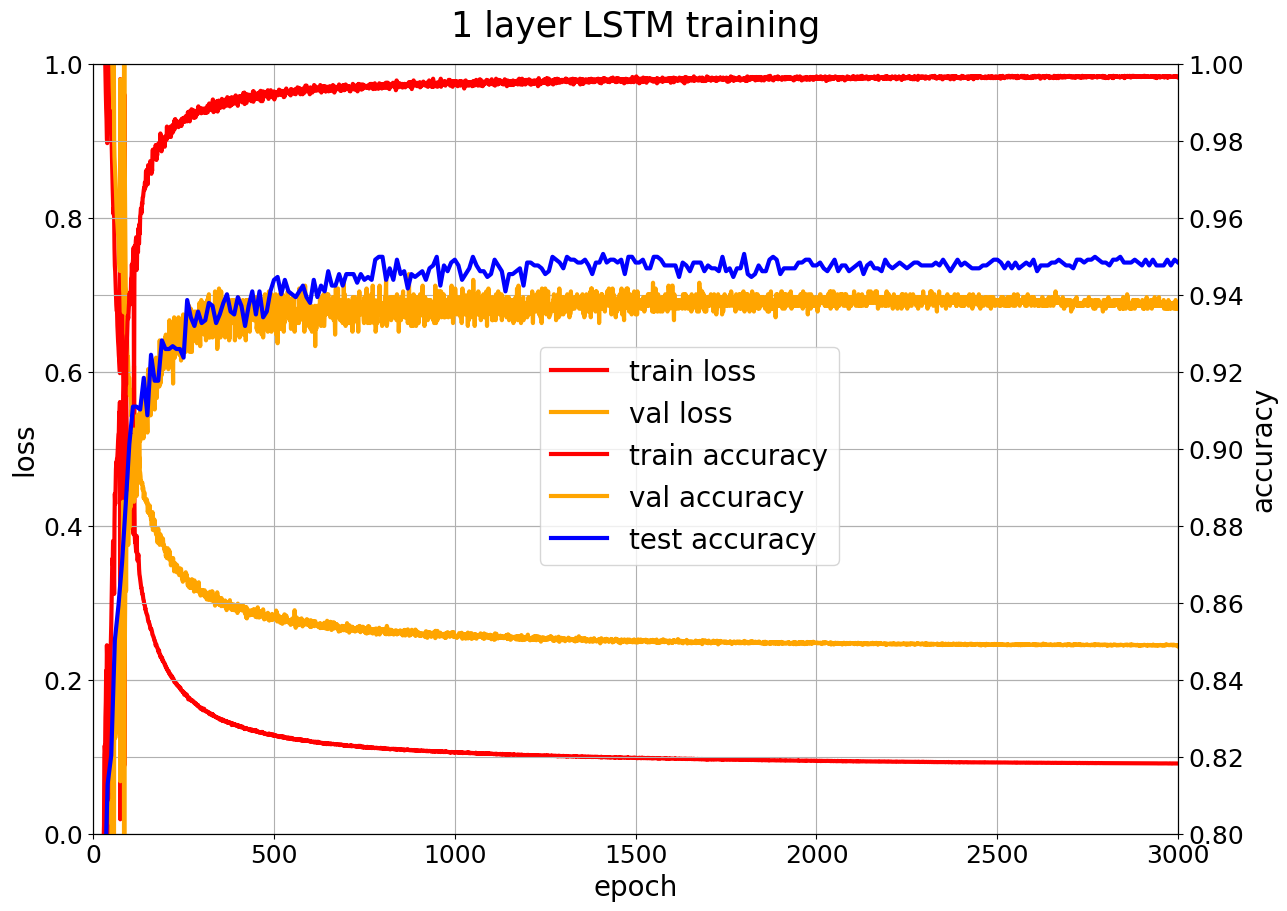

In [ ]:
# AdamW, l2 weight_decay = 0.15, lr = 0.001, lr schedule exp decay gamma = 0.999, with clip_grad_norm_0.01, batch_size = 128, without feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


**AdamW, l2 weight_decay = 0.15, lr = 0.001, lr schedule exp decay gamma = 0.999, with clip_grad_norm_0.01, batch_size = 128, without feature standardization, 1 Layer LSTM**, this seems provides the best result (the above graph).

Text(0.5, 1.025, '1 layer LSTM training')

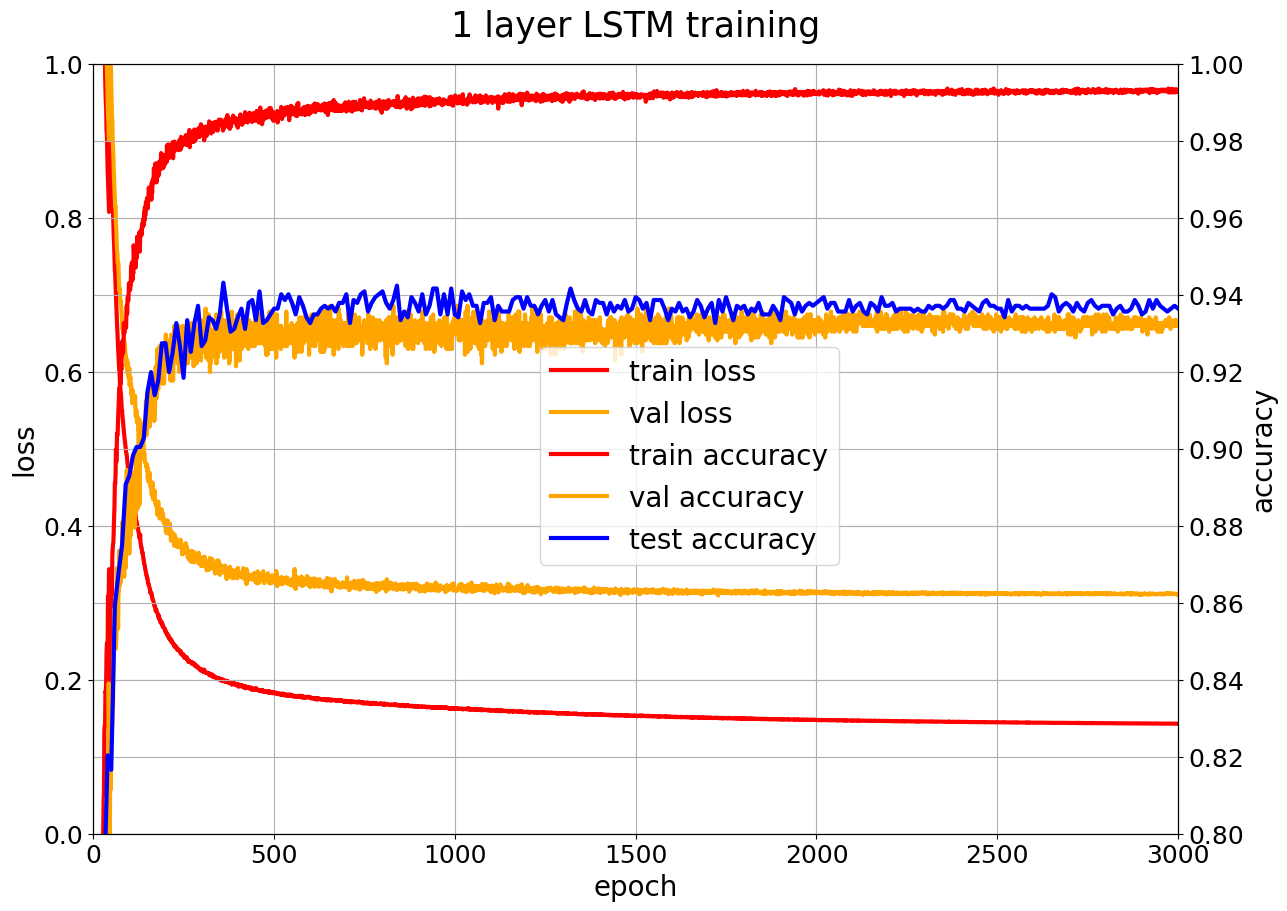

In [12]:
# AdamW, l2 weight_decay = 0.2, lr = 0.001, lr schedule exp decay gamma = 0.999, with clip_grad_norm_0.01, batch_size = 128, without feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

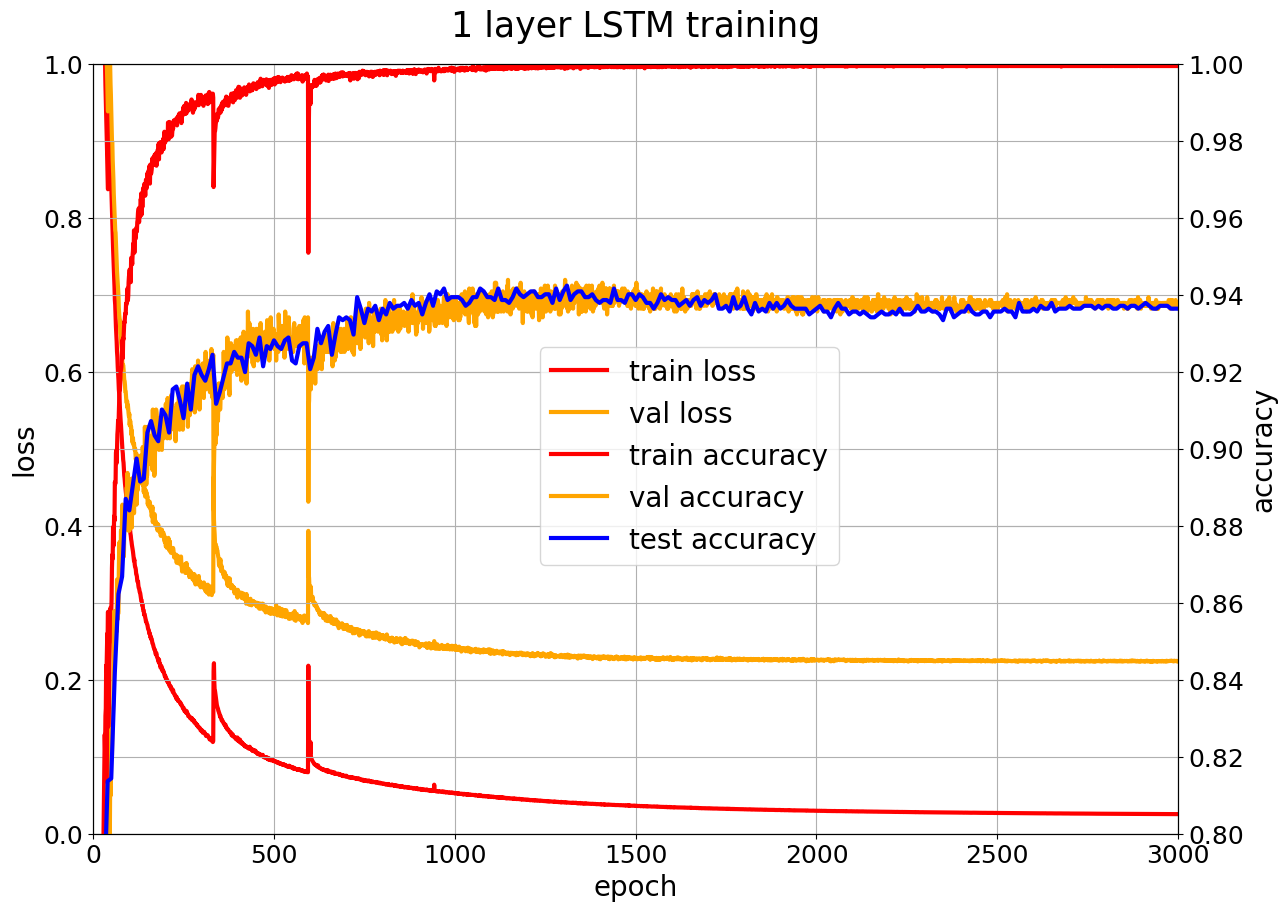

In [12]:
# AdamW, l2 weight_decay = 0.08, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, without feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

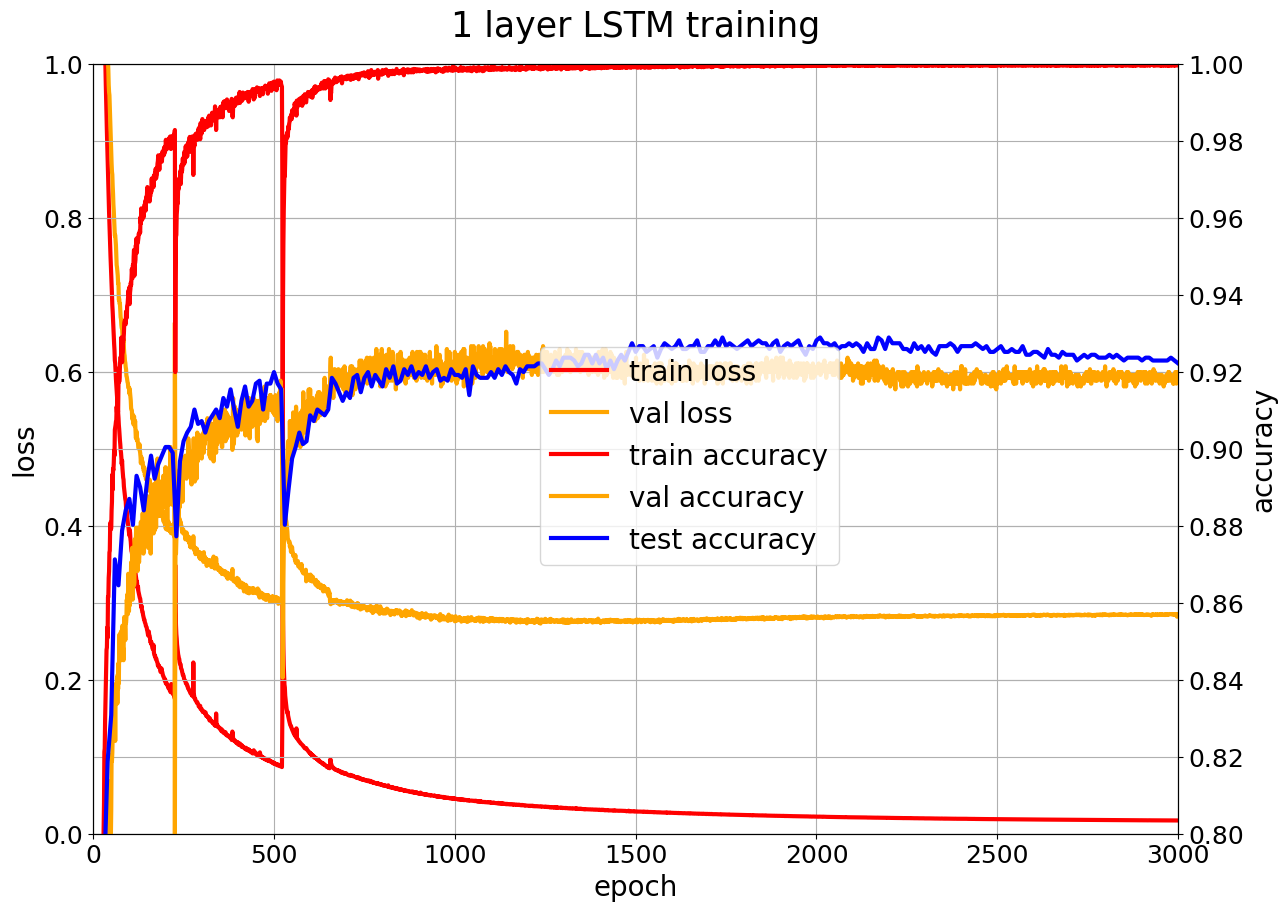

In [ ]:
# AdamW, l2 weight_decay = 0.05, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, without feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

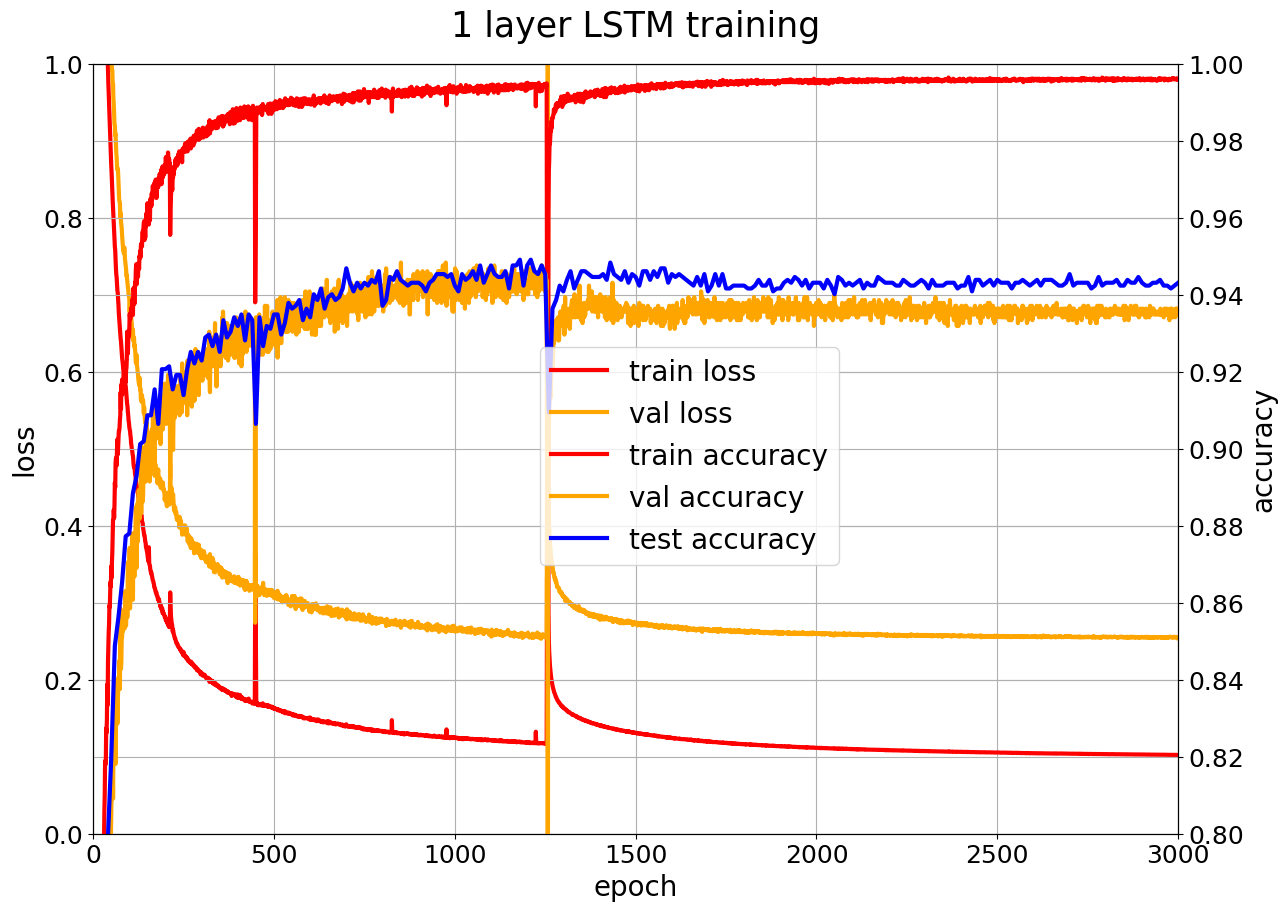

In [ ]:
# AdamW, l2 weight_decay = 0.15, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, without feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


# Cross-Validation and Test Results analysis with feature StandardScaler

In [38]:
print(embryos_for_cross_validation)

['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB27', 'WT-EMB28']


In [40]:
embryos_for_test

['WT-EMB05', 'WT-EMB12', 'WT-EMB19', 'WT-EMB26']

## 6-Fold Cross-Validation Results

In [9]:
with open( './lstm/lstm_full_cv_val_accuracy.json', 'r') as f:
   lstm_full_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_cv_val_accuracy.json', 'r') as f:
   lstm_traj_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_cv_val_accuracy.json', 'r') as f:
   lstm_traj_sf_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_cv_val_accuracy.json', 'r') as f:
   lstm_traj_sf_lf_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_dm_cv_val_accuracy.json', 'r') as f:
   lstm_traj_sf_lf_dm_cv_val_accuracy = json.load(f)

## Test result on test embryo samples

In [10]:
with open( './lstm/lstm_full_test_test_accuracy.json', 'r') as f:
   lstm_full_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_test_test_accuracy.json', 'r') as f:
   lstm_traj_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_test_test_accuracy.json', 'r') as f:
   lstm_traj_sf_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_test_test_accuracy.json', 'r') as f:
   lstm_traj_sf_lf_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_dm_test_test_accuracy.json', 'r') as f:
   lstm_traj_sf_lf_dm_test_test_accuracy = json.load(f)

## lstm full features

In [11]:
# cross-validation final validation accuracy
np.array(lstm_full_cv_val_accuracy)[:,-1]

array([0.83008982, 0.80988024, 0.84356287, 0.84730539, 0.84056886,
       0.74251497])

In [12]:
# cross-validation final validation accuracy mean
np.array(lstm_full_cv_val_accuracy)[:,-1].mean()

0.8189870259481039

In [13]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_full_cv_val_accuracy), axis=1)

array([0.84056886, 0.81511976, 0.8488024 , 0.85404192, 0.84505988,
       0.75299401])

In [14]:
# test result --- final test accuracy
np.array(lstm_full_test_test_accuracy)[-1]

0.8570359281437125

In [15]:
# test result --- max test accuracy
np.array(lstm_full_test_test_accuracy).max()

0.8660179640718563

## lstm trajectory only feature

In [16]:
# cross-validation final validation accuracy
np.array(lstm_traj_cv_val_accuracy)[:,-1]

array([0.68338323, 0.68113772, 0.68787425, 0.68038922, 0.66092814,
       0.59730539])

In [17]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_cv_val_accuracy)[:,-1].mean()

0.6651696606786427

In [18]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_cv_val_accuracy), axis=1)

array([0.69311377, 0.68562874, 0.69386228, 0.68263473, 0.66916168,
       0.60329341])

In [19]:
# test result --- final test accuracy
np.array(lstm_traj_test_test_accuracy)[-1]

0.7380239520958084

In [20]:
# test result --- max test accuracy
np.array(lstm_traj_test_test_accuracy).max()

0.7395209580838323

## lstm trajectory + start_frame feature

In [21]:
# cross-validation final validation accuracy
np.array(lstm_traj_sf_cv_val_accuracy)[:,-1]

array([0.73353293, 0.72754491, 0.73128743, 0.75523952, 0.71856287,
       0.62350299])

In [22]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_sf_cv_val_accuracy)[:,-1].mean()

0.7149451097804391

In [23]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_sf_cv_val_accuracy), axis=1)

array([0.74026946, 0.73203593, 0.73727545, 0.75898204, 0.7245509 ,
       0.63922156])

In [24]:
# test result --- final test accuracy
np.array(lstm_traj_sf_test_test_accuracy)[-1]

0.7649700598802395

In [25]:
# test result --- max test accuracy
np.array(lstm_traj_sf_test_test_accuracy).max()

0.7694610778443114

## lstm trajectory + start_frame + lifespan_frame feature

In [26]:
# cross-validation final validation accuracy
np.array(lstm_traj_sf_lf_cv_val_accuracy)[:,-1]

array([0.72979042, 0.73802395, 0.73053892, 0.75598802, 0.71781437,
       0.62275449])

In [27]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_sf_lf_cv_val_accuracy)[:,-1].mean()

0.715818363273453

In [28]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_sf_lf_cv_val_accuracy), axis=1)

array([0.74251497, 0.74176647, 0.73952096, 0.76272455, 0.7252994 ,
       0.64221557])

In [29]:
# test result --- final test accuracy
np.array(lstm_traj_sf_lf_test_test_accuracy)[-1]

0.7739520958083832

In [30]:
# test result --- max test accuracy
np.array(lstm_traj_sf_lf_test_test_accuracy).max()

0.7776946107784432

## lstm trajectory + start_frame + lifespan_frame + division_orientation_to_mother_cell feature

In [31]:
# cross-validation final validation accuracy
np.array(lstm_traj_sf_lf_dm_cv_val_accuracy)[:,-1]

array([0.82185629, 0.8255988 , 0.82260479, 0.83383234, 0.82260479,
       0.7245509 ])

In [32]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_sf_lf_dm_cv_val_accuracy)[:,-1].mean()

0.8085079840319361

In [33]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_sf_lf_dm_cv_val_accuracy), axis=1)

array([0.82859281, 0.82859281, 0.8248503 , 0.83682635, 0.83083832,
       0.73577844])

In [34]:
# test result --- final test accuracy
np.array(lstm_traj_sf_lf_dm_test_test_accuracy)[-1]

0.8570359281437125

In [35]:
# test result --- max test accuracy
np.array(lstm_traj_sf_lf_dm_test_test_accuracy).max()

0.8585329341317365

# Cross-Validation and Test Results analysis without feature StandardScaler, weight_decay = 0.15

In [9]:
print(embryos_for_cross_validation)

['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB27', 'WT-EMB28']


In [10]:
embryos_for_test

['WT-EMB05', 'WT-EMB12', 'WT-EMB19', 'WT-EMB26']

## 6-Fold Cross-Validation Results

In [11]:
with open( './lstm/lstm_full_cv_val_accuracy.json', 'r') as f:
   lstm_full_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_cv_val_accuracy.json', 'r') as f:
   lstm_traj_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_cv_val_accuracy.json', 'r') as f:
   lstm_traj_sf_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_cv_val_accuracy.json', 'r') as f:
   lstm_traj_sf_lf_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_dm_cv_val_accuracy.json', 'r') as f:
   lstm_traj_sf_lf_dm_cv_val_accuracy = json.load(f)

## Test result on test embryo samples

In [12]:
with open( './lstm/lstm_full_test_test_accuracy.json', 'r') as f:
   lstm_full_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_test_test_accuracy.json', 'r') as f:
   lstm_traj_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_test_test_accuracy.json', 'r') as f:
   lstm_traj_sf_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_test_test_accuracy.json', 'r') as f:
   lstm_traj_sf_lf_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_dm_test_test_accuracy.json', 'r') as f:
   lstm_traj_sf_lf_dm_test_test_accuracy = json.load(f)

## lstm full features

In [13]:
# cross-validation final validation accuracy
np.array(lstm_full_cv_val_accuracy)[:,-1]

array([0.93038922, 0.88847305, 0.90718563, 0.94535928, 0.91092814,
       0.86227545])

In [14]:
# cross-validation final validation accuracy mean
np.array(lstm_full_cv_val_accuracy)[:,-1].mean()

0.9074351297405189

In [15]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_full_cv_val_accuracy), axis=1)

array([0.93787425, 0.90868263, 0.91841317, 0.94835329, 0.91841317,
       0.86901198])

In [16]:
# test result --- final test accuracy
np.array(lstm_full_test_test_accuracy)[-1]

0.9229041916167665

In [17]:
# test result --- max test accuracy
np.array(lstm_full_test_test_accuracy).max()

0.9281437125748503

## lstm trajectory only feature

In [18]:
# cross-validation final validation accuracy
np.array(lstm_traj_cv_val_accuracy)[:,-1]

array([0.81511976, 0.8008982 , 0.81736527, 0.76347305, 0.79416168,
       0.71631737])

In [19]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_cv_val_accuracy)[:,-1].mean()

0.7845558882235529

In [20]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_cv_val_accuracy), axis=1)

array([0.81886228, 0.81511976, 0.82035928, 0.7739521 , 0.7994012 ,
       0.73353293])

In [21]:
# test result --- final test accuracy
np.array(lstm_traj_test_test_accuracy)[-1]

0.8023952095808383

In [22]:
# test result --- max test accuracy
np.array(lstm_traj_test_test_accuracy).max()

0.8046407185628742

## lstm trajectory + start_frame feature

In [23]:
# cross-validation final validation accuracy
np.array(lstm_traj_sf_cv_val_accuracy)[:,-1]

array([0.88248503, 0.83458084, 0.82634731, 0.86377246, 0.80988024,
       0.74326347])

In [24]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_sf_cv_val_accuracy)[:,-1].mean()

0.8267215568862275

In [25]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_sf_cv_val_accuracy), axis=1)

array([0.89071856, 0.83832335, 0.84655689, 0.87275449, 0.82634731,
       0.75374251])

In [26]:
# test result --- final test accuracy
np.array(lstm_traj_sf_test_test_accuracy)[-1]

0.8450598802395209

In [27]:
# test result --- max test accuracy
np.array(lstm_traj_sf_test_test_accuracy).max()

0.8517964071856288

## lstm trajectory + start_frame + lifespan_frame feature

In [28]:
# cross-validation final validation accuracy
np.array(lstm_traj_sf_lf_cv_val_accuracy)[:,-1]

array([0.87275449, 0.8248503 , 0.83083832, 0.84655689, 0.84730539,
       0.76497006])

In [29]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_sf_lf_cv_val_accuracy)[:,-1].mean()

0.8312125748502993

In [30]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_sf_lf_cv_val_accuracy), axis=1)

array([0.8757485 , 0.82784431, 0.84431138, 0.86976048, 0.8502994 ,
       0.78892216])

In [31]:
# test result --- final test accuracy
np.array(lstm_traj_sf_lf_test_test_accuracy)[-1]

0.8420658682634731

In [32]:
# test result --- max test accuracy
np.array(lstm_traj_sf_lf_test_test_accuracy).max()

0.8502994011976048

## lstm trajectory + start_frame + lifespan_frame + division_orientation_to_mother_cell feature

In [33]:
# cross-validation final validation accuracy
np.array(lstm_traj_sf_lf_dm_cv_val_accuracy)[:,-1]

array([0.93712575, 0.89221557, 0.90269461, 0.91841317, 0.89520958,
       0.84805389])

In [34]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_sf_lf_dm_cv_val_accuracy)[:,-1].mean()

0.8989520958083833

In [35]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_sf_lf_dm_cv_val_accuracy), axis=1)

array([0.94086826, 0.90718563, 0.91017964, 0.9251497 , 0.89820359,
       0.85928144])

In [36]:
# test result --- final test accuracy
np.array(lstm_traj_sf_lf_dm_test_test_accuracy)[-1]

0.9229041916167665

In [37]:
# test result --- max test accuracy
np.array(lstm_traj_sf_lf_dm_test_test_accuracy).max()

0.9281437125748503

# Cross-Validation and Test Results analysis without feature StandardScaler, weight_decay = 0.1

## 6-Fold Cross-Validation Results

In [38]:
with open( './lstm/lstm_full_cv_val_accuracy_wd01.json', 'r') as f:
   lstm_full_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_cv_val_accuracy_wd01.json', 'r') as f:
   lstm_traj_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_cv_val_accuracy_wd01.json', 'r') as f:
   lstm_traj_sf_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_cv_val_accuracy_wd01.json', 'r') as f:
   lstm_traj_sf_lf_cv_val_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_dm_cv_val_accuracy_wd01.json', 'r') as f:
   lstm_traj_sf_lf_dm_cv_val_accuracy = json.load(f)

## Test result on test embryo samples

In [39]:
with open( './lstm/lstm_full_test_test_accuracy_wd01.json', 'r') as f:
   lstm_full_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_test_test_accuracy_wd01.json', 'r') as f:
   lstm_traj_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_test_test_accuracy_wd01.json', 'r') as f:
   lstm_traj_sf_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_test_test_accuracy_wd01.json', 'r') as f:
   lstm_traj_sf_lf_test_test_accuracy = json.load(f)
with open( './lstm/lstm_traj_sf_lf_dm_test_test_accuracy_wd01.json', 'r') as f:
   lstm_traj_sf_lf_dm_test_test_accuracy = json.load(f)

## lstm full features

In [40]:
# cross-validation final validation accuracy
np.array(lstm_full_cv_val_accuracy)[:,-1]

array([0.93488024, 0.90643713, 0.91392216, 0.94386228, 0.91541916,
       0.86152695])

In [41]:
# cross-validation final validation accuracy mean
np.array(lstm_full_cv_val_accuracy)[:,-1].mean()

0.9126746506986029

In [42]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_full_cv_val_accuracy), axis=1)

array([0.94386228, 0.91092814, 0.91916168, 0.94610778, 0.91766467,
       0.86676647])

In [43]:
# test result --- final test accuracy
np.array(lstm_full_test_test_accuracy)[-1]

0.9229041916167665

In [44]:
# test result --- max test accuracy
np.array(lstm_full_test_test_accuracy).max()

0.9273952095808383

## lstm trajectory only feature

In [45]:
# cross-validation final validation accuracy
np.array(lstm_traj_cv_val_accuracy)[:,-1]

array([0.80613772, 0.81511976, 0.82260479, 0.82335329, 0.75523952,
       0.70958084])

In [46]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_cv_val_accuracy)[:,-1].mean()

0.7886726546906188

In [47]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_cv_val_accuracy), axis=1)

array([0.80913174, 0.82784431, 0.82784431, 0.83607784, 0.80688623,
       0.7252994 ])

In [48]:
# test result --- final test accuracy
np.array(lstm_traj_test_test_accuracy)[-1]

0.8360778443113772

In [49]:
# test result --- max test accuracy
np.array(lstm_traj_test_test_accuracy).max()

0.842814371257485

## lstm trajectory + start_frame feature

In [50]:
# cross-validation final validation accuracy
np.array(lstm_traj_sf_cv_val_accuracy)[:,-1]

array([0.86976048, 0.83607784, 0.84131737, 0.88173653, 0.82110778,
       0.77020958])

In [51]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_sf_cv_val_accuracy)[:,-1].mean()

0.8367015968063872

In [52]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_sf_cv_val_accuracy), axis=1)

array([0.8757485 , 0.84131737, 0.85404192, 0.88922156, 0.8255988 ,
       0.7739521 ])

In [53]:
# test result --- final test accuracy
np.array(lstm_traj_sf_test_test_accuracy)[-1]

0.8562874251497006

In [54]:
# test result --- max test accuracy
np.array(lstm_traj_sf_test_test_accuracy).max()

0.8660179640718563

## lstm trajectory + start_frame + lifespan_frame feature

In [55]:
# cross-validation final validation accuracy
np.array(lstm_traj_sf_lf_cv_val_accuracy)[:,-1]

array([0.87799401, 0.82859281, 0.84730539, 0.85553892, 0.84805389,
       0.78667665])

In [56]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_sf_lf_cv_val_accuracy)[:,-1].mean()

0.8406936127744511

In [57]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_sf_lf_cv_val_accuracy), axis=1)

array([0.87949102, 0.83607784, 0.85628743, 0.87724551, 0.85853293,
       0.79491018])

In [58]:
# test result --- final test accuracy
np.array(lstm_traj_sf_lf_test_test_accuracy)[-1]

0.8555389221556886

In [59]:
# test result --- max test accuracy
np.array(lstm_traj_sf_lf_test_test_accuracy).max()

0.8690119760479041

## lstm trajectory + start_frame + lifespan_frame + division_orientation_to_mother_cell feature

In [60]:
# cross-validation final validation accuracy
np.array(lstm_traj_sf_lf_dm_cv_val_accuracy)[:,-1]

array([0.92365269, 0.91317365, 0.90568862, 0.91467066, 0.89820359,
       0.85404192])

In [61]:
# cross-validation final validation accuracy mean
np.array(lstm_traj_sf_lf_dm_cv_val_accuracy)[:,-1].mean()

0.9015718562874252

In [62]:
# cross-validation final validation accuracy max
np.max(np.array(lstm_traj_sf_lf_dm_cv_val_accuracy), axis=1)

array([0.92814371, 0.91916168, 0.91092814, 0.92290419, 0.90344311,
       0.86302395])

In [63]:
# test result --- final test accuracy
np.array(lstm_traj_sf_lf_dm_test_test_accuracy)[-1]

0.9244011976047904

In [64]:
# test result --- max test accuracy
np.array(lstm_traj_sf_lf_dm_test_test_accuracy).max()

0.9288922155688623